<a href="https://colab.research.google.com/github/Randhir123/iisc-cds/blob/main/Randhir_M3_NB_MiniProject_02_Fare_Amount_Prediction_Using_Dask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science
## A program by IISc and TalentSprint
### Mini-Project: Implementation of Linear Regression on a Large Dataset Using Dask Library

## Learning Objectives

At the end of the mini-project, you will be able to :

- understand how dask handles large dataset over pandas dataframe
- perform exploratory data analysis on a large dataset (2 Million rows) using dask
- implement linear regression model using dask library and make predictions


## Problem Statement

 Predict the taxi fare amount in New York city using Dask-ML.

## Information

### Dask
[Dask](https://dask.pydata.org/en/latest/) is an open source project that gives abstractions over NumPy Arrays, Pandas Dataframes and regular lists, allowing you to run operations on them in parallel, using multicore processing.

We can summarize the basics of Dask as follows:

* processes data that doesn’t fit into memory by breaking it into blocks and specifying task chains

* parallelizes execution of tasks across cores and even nodes of a cluster

* moves computation to the data rather than the other way around, to minimize communication overhead

### Dataset

The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. Its variables are as follows:
![Dataset](https://cdn.iisc.talentsprint.com/CDS/Images/NYC_Taxi_data_description.png)




Note that the features the ' Dask_MP_dataset.csv' file that is provided for this miniproject varies slightly in terms of included features, as compared to the original dataset described above. Please proceed with the provided csv file.

## Grading = 10 Points

In [2]:
#@title Install Dask dependencies and restart runtime
!pip -qq install dask-ml
!pip -qq install dask
!pip -qq install dask[complete]
!pip -qq install dask distributed
!pip -qq install mimesis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.8/149.8 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 12.4 MB/s eta 0:00:00


#### Importing Necessary Packages

In [3]:
import warnings
warnings.filterwarnings('ignore')
import dask
import dask.dataframe as dd
import dask.array as da
from dask_ml.linear_model import LinearRegression
from dask_ml.model_selection import train_test_split
from dask_ml.metrics import mean_squared_error, r2_score
from dask.distributed import Client
import time as time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from dask.distributed import Client, progress
client = Client()

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:32871
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:45669'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:36873'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:39943', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:39943
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:40748
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:36113', name: 1, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:36113
INFO:distributed.core:Sta

In [4]:
#@title Download the data
!wget https://cdn.iisc.talentsprint.com/CDS/MiniProjects/Dask_MP_dataset.csv

--2024-04-26 03:33:45--  https://cdn.iisc.talentsprint.com/CDS/MiniProjects/Dask_MP_dataset.csv
Resolving cdn.iisc.talentsprint.com (cdn.iisc.talentsprint.com)... 172.105.52.210
Connecting to cdn.iisc.talentsprint.com (cdn.iisc.talentsprint.com)|172.105.52.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 231900522 (221M) [application/octet-stream]
Saving to: ‘Dask_MP_dataset.csv’

Dask_MP_dataset.csv 100%[===================>] 221.16M  13.6MB/s    in 19s     

2024-04-26 03:34:05 (11.8 MB/s) - ‘Dask_MP_dataset.csv’ saved [231900522/231900522]



#### Exercise 1: Read the dataset using dask library and compare the time of execution with pandas library.

**Hint:** pass `dtype` for passenger_count as `int64`

In [5]:
%%time
ddf = dd.read_csv('/content/Dask_MP_dataset.csv', dtype={'passenger_count': 'int64'})

CPU times: user 44.7 ms, sys: 12.4 ms, total: 57.1 ms
Wall time: 106 ms


#### Use pandas to read the dataset and compare the time taken

In [6]:
%%time
df = pd.read_csv('/content/Dask_MP_dataset.csv', dtype={'passenger_count': 'int64'})

CPU times: user 7.51 s, sys: 1.67 s, total: 9.18 s
Wall time: 12.3 s


In [7]:
ddf.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [8]:
ddf.compute().shape

(2000000, 9)

In [9]:
ddf.dtypes

Unnamed: 0                     int64
key                  string[pyarrow]
fare_amount                  float64
pickup_datetime      string[pyarrow]
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
passenger_count                int64
dtype: object

In [10]:
ddf.describe().compute()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,1.999986e+06,1.999986e+06,2.000000e+06
mean,9.999995e+05,1.134779e+01,-7.252321e+01,3.992963e+01,-7.252395e+01,3.992808e+01,1.684113e+00
std,5.773504e+05,9.852883e+00,1.286804e+01,7.983352e+00,1.277497e+01,1.032382e+01,1.314982e+00
min,0.000000e+00,-6.200000e+01,-3.377681e+03,-3.458665e+03,-3.383297e+03,-3.461541e+03,0.000000e+00
25%,3.350920e+05,6.000000e+00,-7.399204e+01,4.073498e+01,-7.399139e+01,4.073406e+01,1.000000e+00
50%,8.367612e+05,8.500000e+00,-7.398179e+01,4.075270e+01,-7.398014e+01,4.075316e+01,1.000000e+00
75%,1.336491e+06,1.250000e+01,-7.396710e+01,4.076713e+01,-7.396364e+01,4.076812e+01,2.000000e+00
max,1.999999e+06,1.273310e+03,2.856442e+03,2.621628e+03,3.414307e+03,3.345917e+03,2.080000e+02


### Data Analysis (2 Points)



#### Exercise 2: Drop the unnecessary columns. Also drop the duplicate rows and the rows having null values.

**Hint:** Drop those columns which are not useful in EDA as well as model implementation

In [11]:
""" Drop unnecessary columns """
ddf = ddf.drop(columns=['Unnamed: 0', 'key'])

In [12]:
ddf.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [13]:
""" Drop duplicate rows """
ddf = ddf.drop_duplicates()
ddf.compute().shape

(1999997, 7)

In [14]:
""" drop NA rows """
ddf = ddf.dropna()
ddf.compute().shape

(1999983, 7)

#### Exercise 3: Visualize the target variable, i.e., `fare_amount` to study the fare distribution, using a histogram density plot. Analyze the fare_amount distribution, try to visualize it for a range of [0, 60].

**Hint:** [sns.hisplot()](https://stackoverflow.com/questions/51027636/seaborn-histogram-with-bigdata/51027895) and use `.between` to plot the graph for given range


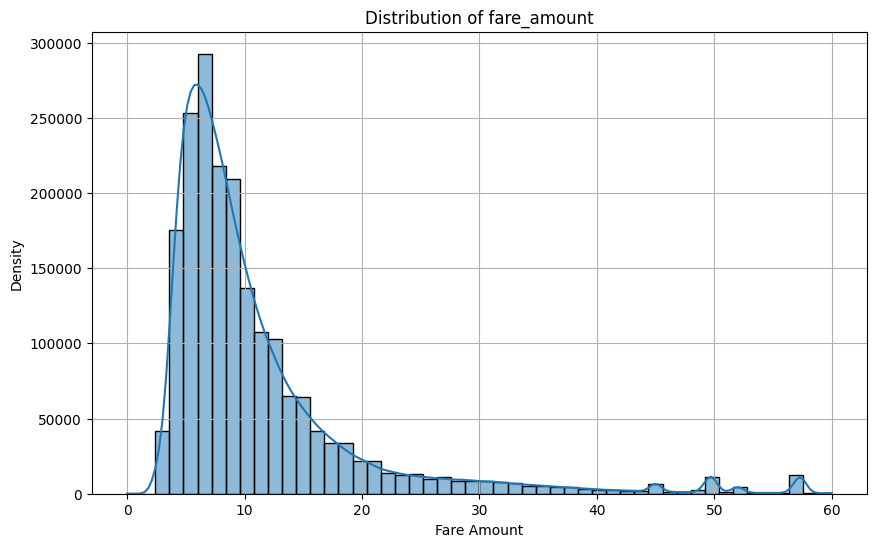

In [15]:
""" explore and plot the density plot of fare_amount """
ddf_filtered = ddf[ddf['fare_amount'].between(0, 60)]

plt.figure(figsize=(10, 6))
sns.histplot(ddf_filtered['fare_amount'].compute(), bins=50, kde=True)
plt.title('Distribution of fare_amount')
plt.xlabel('Fare Amount')
plt.ylabel('Density')
plt.grid(True)
plt.show()

#### Observe the number of workers and cores running in your machine

Initialize a client and observe how many workers are working and the number of cores utilizing for the given data set.

In [16]:
""" Initialize a client """
workers_info = client.scheduler_info()['workers']
num_workers = len(workers_info)
print(f"Number of workers: {num_workers}")

total_cores = sum(client.ncores().values())
print(f"Total number of cores: {total_cores}")

Number of workers: 2
Total number of cores: 2


### EDA based on Time (2 Points)

#### Exercise 4: Extract day of the week (dow), hour, month and year from `pickup_datetime`.

**Hint:** use `pd.to_datetime()` function as dask does not have this functionality in it.

Remember to use `.compute()` while passing the dask dataframe in defined function.

In [17]:
def extract_datetime_features(ddf):

    ddf['pickup_datetime'] = ddf['pickup_datetime'].map_partitions(
        pd.to_datetime, meta=('pickup_datetime', 'datetime64[ns]')
    )

    # Extract features
    ddf['dow'] = ddf['pickup_datetime'].dt.dayofweek
    ddf['hour'] = ddf['pickup_datetime'].dt.hour
    ddf['month'] = ddf['pickup_datetime'].dt.month
    ddf['year'] = ddf['pickup_datetime'].dt.year

    return ddf.compute()

ddf = extract_datetime_features(ddf)
ddf.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dow,hour,month,year
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,0,17,6,2009
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,1,16,1,2010
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,3,0,8,2011
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,5,4,4,2012
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,1,7,3,2010


#### Exercise 5: a.) Plot the taxi trip by hour of the day

* Partition the data into segments using `dask.from_pandas()`

* Plot the taxi trip for hour of the day. **Hint:** [sns.catplot](https://seaborn.pydata.org/generated/seaborn.catplot.html)

<Figure size 1000x600 with 0 Axes>

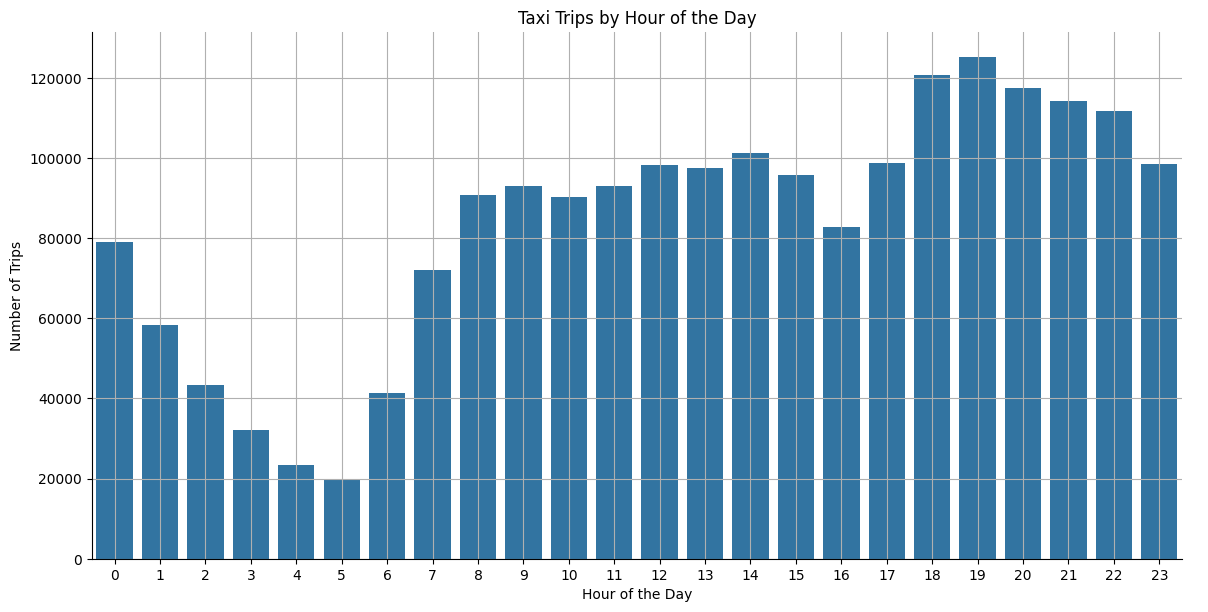

In [18]:
""" taxi trip repartition by hour of the day """
ddf = dd.from_pandas(ddf, npartitions=4)
ddf['hour'] = ddf['pickup_datetime'].dt.hour

plt.figure(figsize=(10, 6))
sns.catplot(x='hour', kind='count', data=ddf.compute(), height=6, aspect=2)
plt.title('Taxi Trips by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.grid(True)
plt.show()

#### Exercise 5: b.) Plot the taxi trip repartition by day of the week (dow)

INFO:distributed.core:Event loop was unresponsive in Nanny for 3.08s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 3.07s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.07s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


<Figure size 1000x600 with 0 Axes>

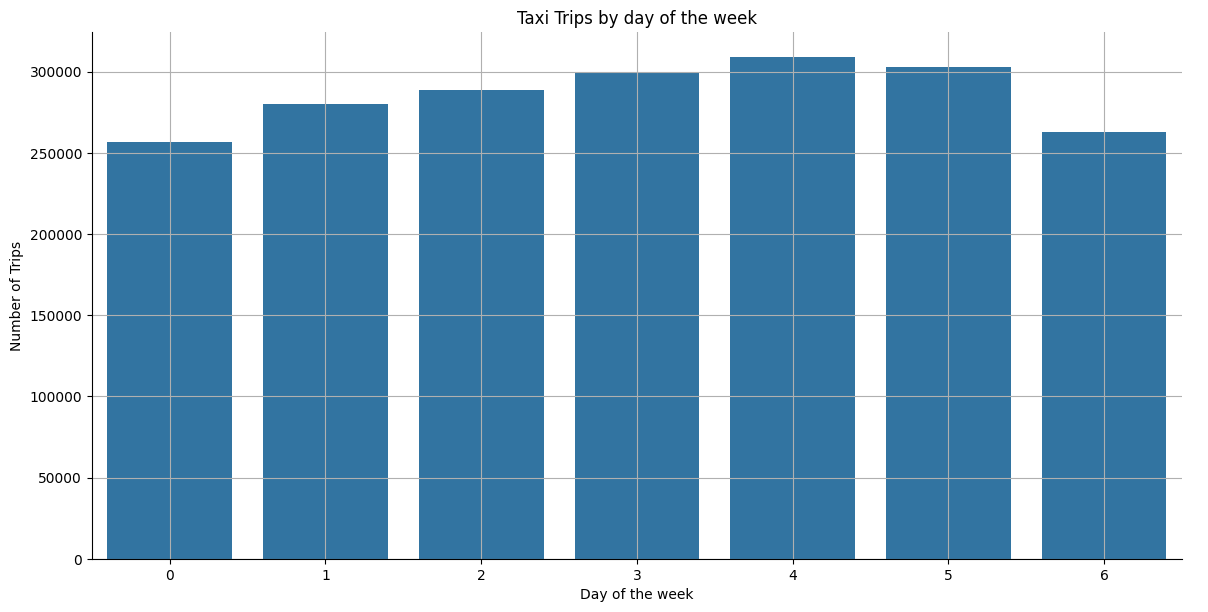

In [19]:
""" taxi trip repartition by day of the week """

plt.figure(figsize=(10, 6))
sns.catplot(x='dow', kind='count', data=ddf.compute(), height=6, aspect=2)
plt.title('Taxi Trips by day of the week')
plt.xlabel('Day of the week')
plt.ylabel('Number of Trips')
plt.grid(True)
plt.show()

#### Exercise 6: a.) Draw a plot between the target variable and passenger count and analyze it.

INFO:distributed.utils_perf:full garbage collection released 297.47 MiB from 4293 reference cycles (threshold: 9.54 MiB)
INFO:distributed.core:Event loop was unresponsive in Scheduler for 4.75s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.76s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.76s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


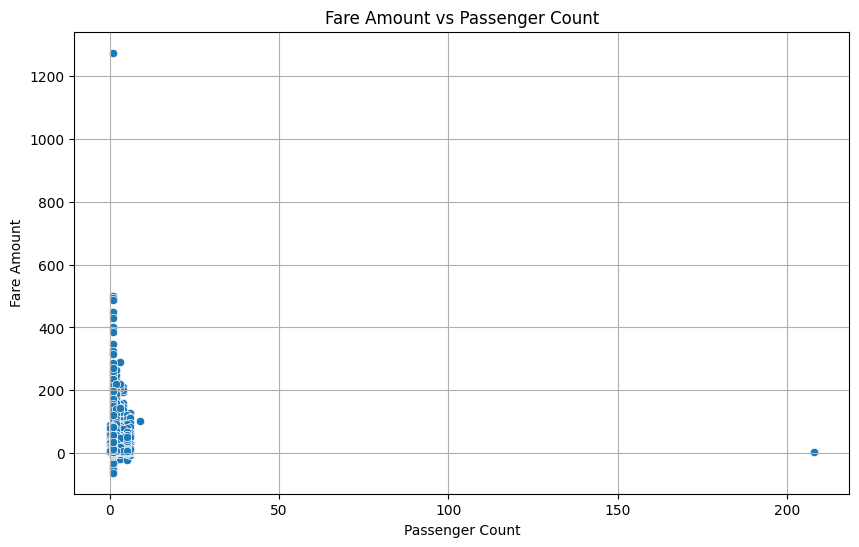

In [20]:
""" passenger count feature """
plt.figure(figsize=(10, 6))
sns.scatterplot(x='passenger_count', y='fare_amount', data=ddf.compute())
plt.title('Fare Amount vs Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Fare Amount')
plt.grid(True)
plt.show()

In [21]:

mean_passenger_count = ddf['passenger_count'].mean().compute()
std_passenger_count = ddf['passenger_count'].std().compute()

outlier_threshold = mean_passenger_count + 3 * std_passenger_count
ddf = ddf[ddf['passenger_count'] <= outlier_threshold]

df = ddf.compute()

INFO:distributed.core:Event loop was unresponsive in Scheduler for 4.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


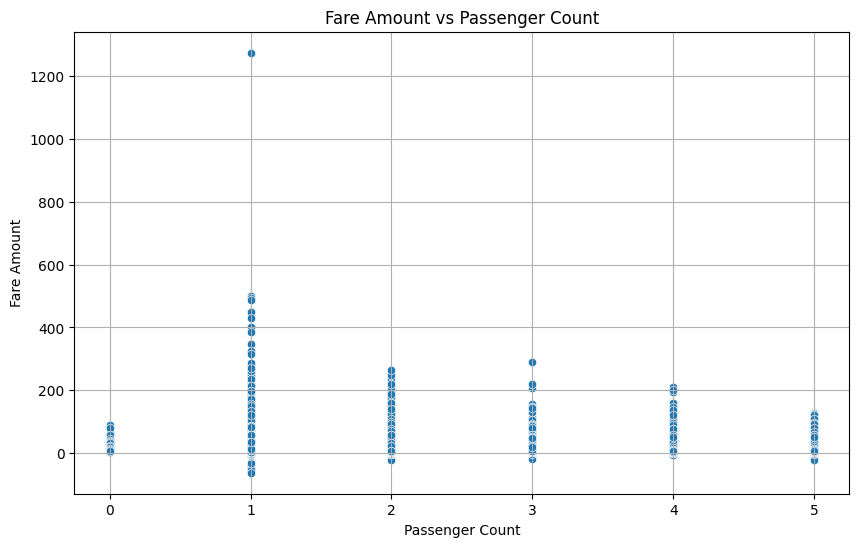

In [22]:
""" passenger count feature """
plt.figure(figsize=(10, 6))
sns.scatterplot(x='passenger_count', y='fare_amount', data=ddf.compute())
plt.title('Fare Amount vs Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Fare Amount')
plt.grid(True)
plt.show()

#### Exercise 6: b.) Draw a plot between the target variable and hour and analyze it.

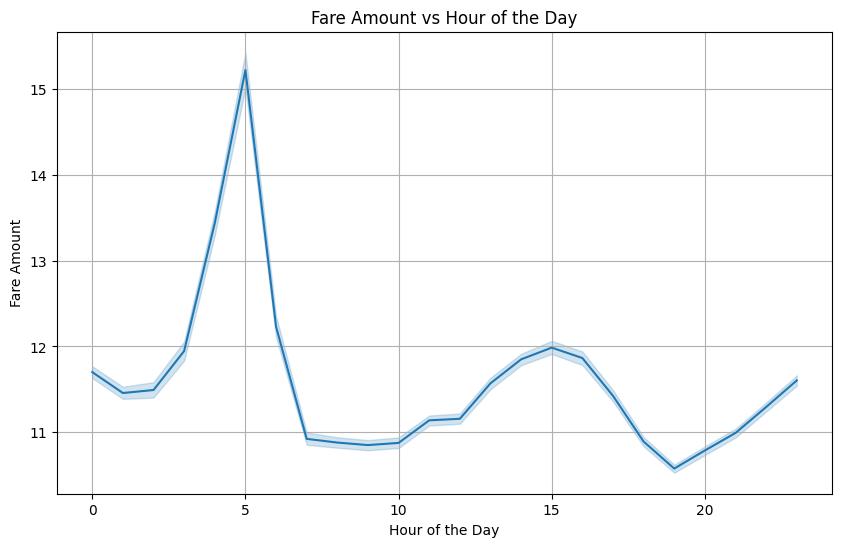

In [23]:
""" fare amount by hour """
plt.figure(figsize=(10, 6))
sns.lineplot(x='hour', y='fare_amount', data=ddf.compute())
plt.title('Fare Amount vs Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Fare Amount')
plt.grid(True)
plt.show()

### Feature Engineering (1 Point)

#### Exercise 7: Compute the Haversine distance between pickup and dropoff point

* Convert the latitude and longitude co-rodinates to radians

* Calculate the Haversine distance

  **Hint:** [haversine_distances](https://towardsdatascience.com/heres-how-to-calculate-distance-between-2-geolocations-in-python-93ecab5bbba4)

* Add the "distance" feature to the dataset and plot its distribution

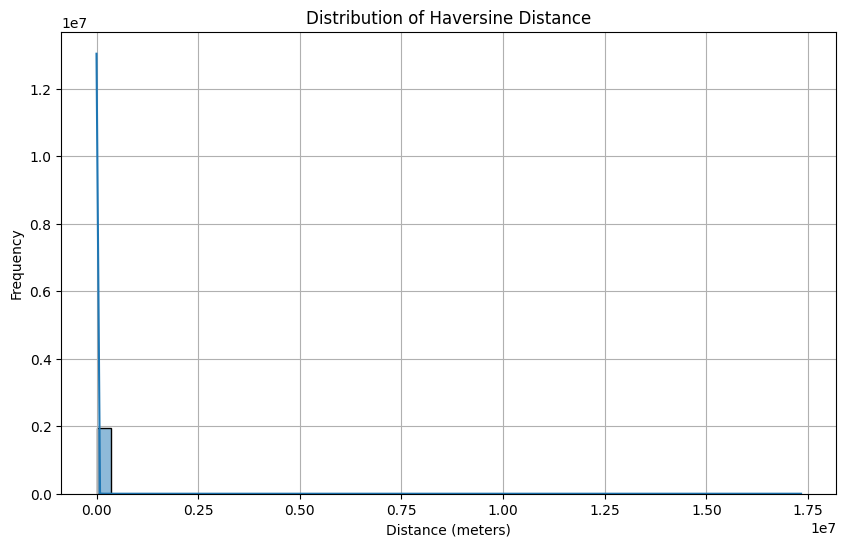

In [24]:
""" distance feature """
ddf['pickup_latitude_rad'] = np.radians(ddf['pickup_latitude'])
ddf['pickup_longitude_rad'] = np.radians(ddf['pickup_longitude'])
ddf['dropoff_latitude_rad'] = np.radians(ddf['dropoff_latitude'])
ddf['dropoff_longitude_rad'] = np.radians(ddf['dropoff_longitude'])

# Calculate Haversine distance
def haversine(lon1, lat1, lon2, lat2):
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    distance_m = 6371000 * c
    return distance_m

ddf['distance'] = haversine(ddf['pickup_longitude_rad'], ddf['pickup_latitude_rad'], ddf['dropoff_longitude_rad'], ddf['dropoff_latitude_rad'])

# Plot the distribution of the distance feature
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(ddf['distance'].compute(), bins=50, kde=True)
plt.title('Distribution of Haversine Distance')
plt.xlabel('Distance (meters)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

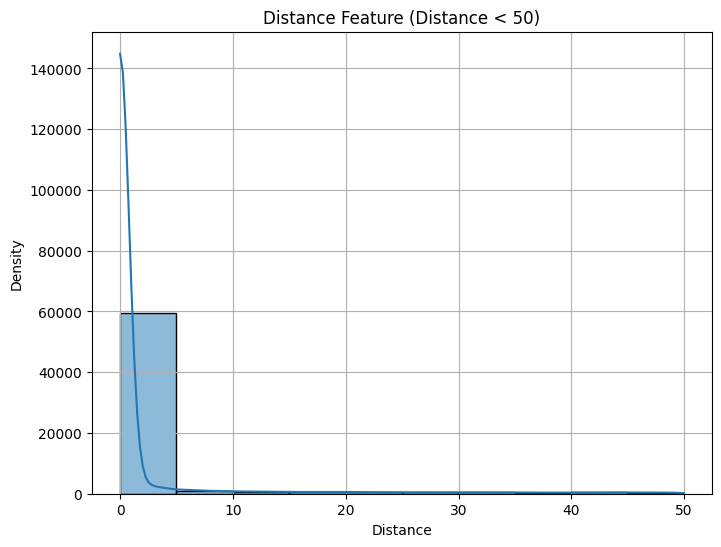

In [36]:
""" plot the distance feature (take distance < 50) """

filtered_ddf = ddf[ddf['distance'] < 50]
filtered_df = filtered_ddf.compute()

plt.figure(figsize=(8, 6))
sns.histplot(filtered_df['distance'], bins=10, kde=True)
plt.title('Distance Feature (Distance < 50)')
plt.xlabel('Distance')
plt.ylabel('Density')
plt.grid(True)
plt.show()

### Correlation between distance and fare amount (1 Point)

In [37]:
""" correlation between fare_amount and distance """
correlation = ddf['distance'].corr(ddf['fare_amount']).compute()

print("Correlation between distance and fare amount:", correlation)

Correlation between distance and fare amount: 0.024901163515440035


### Preparing dataset for model implementation

**Note:** Use the above modified dataset for modelling.

In [38]:
from copy import copy
ddf_model = copy(ddf)

### Removing outliers from training set Based on Coordinates (1 Point)

#### Exercise 8: Remove the outliers using the given latitude and longitude features from the dataset. We need to analyze the data of taxi within New York City.

**Hint:** Given the co-ordinates of New York city are Latitude: 40.7128° and Longitude: -74.0060°. You can include the pickup and drop off points such that there left and right value mean will be the given co-ordinate value.

Also, choose nearest extreme values.

Use `.between()` and pass left and right value attributes accordingly.

In [39]:
""" remove the outliers in pickup latitude longitude and drop off latitude and longitude """
nyc_latitude = 40.7128
nyc_longitude = -74.0060

tolerance = 0.5

ddf_model = ddf_model[
    (ddf_model['pickup_latitude'].between(nyc_latitude - tolerance, nyc_latitude + tolerance)) &
    (ddf_model['pickup_longitude'].between(nyc_longitude - tolerance, nyc_longitude + tolerance)) &
    (ddf_model['dropoff_latitude'].between(nyc_latitude - tolerance, nyc_latitude + tolerance)) &
    (ddf_model['dropoff_longitude'].between(nyc_longitude - tolerance, nyc_longitude + tolerance))
]

df_model = ddf_model.compute()

INFO:distributed.utils_perf:full garbage collection released 89.69 MiB from 27184 reference cycles (threshold: 9.54 MiB)


### Modelling (3 Points)

#### Exercise 9: Divide the data into train and test splits with X as feature variables and y as target variable

* Divide data into train test split with 70-30 ratio, Hint: `train_test_split()`

* As dask functions operate lazily so, before calling `.fit()` function, call the dask dataframe with `.compute()`.
* Convert X_train and y_train into array using `.values` as [dask's](https://ml.dask.org/modules/api.html) `.fit()` function takes array as attribute

In [44]:
""" select the target and feature variables and split the data into train and test """
X = ddf_model.drop(columns=['fare_amount', 'pickup_datetime'])
y = ddf_model['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_array = X_train.compute().values
X_test_array = X_test.compute().values
y_train_array = y_train.compute().values
y_test_array = y_test.compute().values

In [45]:
X.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dow,hour,month,year,pickup_latitude_rad,pickup_longitude_rad,dropoff_latitude_rad,dropoff_longitude_rad,distance
0,-73.844311,40.721319,-73.841610,40.712278,1,0,17,6,2009,0.710721,-1.288826,0.710563,-1.288779,1030.763935
0,-74.006425,40.744747,-73.981225,40.769387,3,4,18,5,2009,0.711130,-1.291656,0.711560,-1.291216,3465.831091
0,-74.009455,40.724818,-73.965932,40.638384,1,6,10,9,2014,0.710782,-1.291709,0.709274,-1.290949,10287.899573
1,-74.016048,40.711303,-73.979268,40.782004,1,1,16,1,2010,0.710546,-1.291824,0.711780,-1.291182,8450.133596
1,-73.982811,40.766794,-73.982048,40.774986,1,0,14,8,2010,0.711515,-1.291244,0.711658,-1.291230,913.172137


In [46]:
reg = LinearRegression()
reg.fit(X_train_array, y_train_array)

LinearRegression()

#### Exercise 10: Predict the test data and calculate the mean squared error and r2 score.

**Hint:** Remember to call `.compute()` function as dask functions operate lazily and convert the dask dataframe to `.values` (Array type) as suggested in above exercise

In [68]:
""" predict the values """
y_pred = reg.predict(X_test_array)

In [69]:
""" compute mean squared error and r2_score """
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test_array, y_pred)
r2 = r2_score(y_test_array, y_pred)

print("Mean Squared Error:", mse)
print("R2 Score:", r2)

Mean Squared Error: 24.000247012618427
R2 Score: 0.7432850392315262


### Report Analysis
* Discuss the pros and cons of using dask
* Derive the insights and discuss
* Comment on the performance metrics (MSE, $R^2$ score)
